## This notebook aims to reproduce the generation of the logistic regression classifier on MinION variants. 

We start from the three MinION variants tables listed below. These three tables had variants with frequencies < 0.03 filtered out. 
- BC01.variants.0.03.txt
- BC02.variants.0.03.txt
- BC03.variants.0.03.txt

These three tables were generated by [Nicholas J. Loman](https://github.com/nickloman/zika-isnv) using the following commands: 
- python scripts/freqs.py --snpfreqmin 0.03 BC01.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC01.variants.0.03.txt
- python scripts/freqs.py --snpfreqmin 0.03 BC02.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC02.variants.0.03.txt
- python scripts/freqs.py --snpfreqmin 0.03 BC03.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC03.variants.0.03.txt

These commands are taken from "process_data.sh" by [Nicholas J. Loman](https://github.com/nickloman/zika-isnv) on Github. 

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library("tidyverse")
library("ggplot2")
#library("plotROC")
options(readr.num_columns = 0)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.2     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
%%R 
# Read in the three datasets "BC01.variants.0.03.txt", "BC02.variants.0.03.txt", "BC03.variants.0.03.txt". 
barcode1snps=read_tsv("BC01.variants.0.03.txt")
barcode1snps$replica = 'a'

barcode2snps=read_tsv("BC02.variants.0.03.txt")
barcode2snps$replica = 'b'

barcode3snps=read_tsv("BC03.variants.0.03.txt")
barcode3snps$replica = 'c'

In [4]:
%%R
# Merge the three datasets
minion_variants=rbind(barcode1snps, barcode2snps, barcode3snps)

Remove position in amplicons with primer mismatches.

These positions are described in "expectedpositions.txt", where each of the position are labelled by: 
- "REMOVE": positions to be removed, because they are located in the amplicons with primer mismatches
- "TRUE": true positives variants by comparing the consensus nt sequence of the gb records KX087101 and KU955593. 
- "FALSE": false positives, variants detected by MinION, but not labelled as "TRUE". 

In [5]:
%%R 
expectedpositions=read_tsv("expectedpositions.txt")

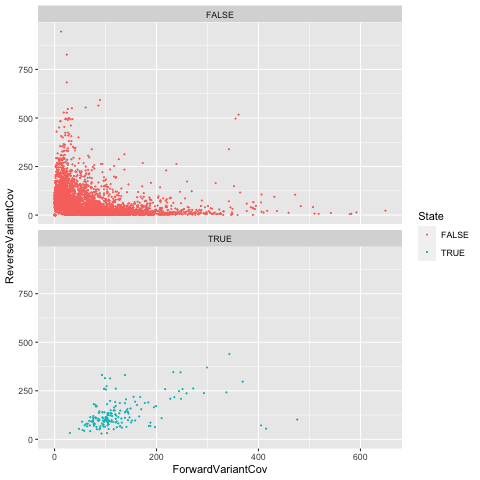

In [6]:
%%R 
# Remove variants with the label "REMOVE"
minion_variants_positions=minion_variants %>%
   left_join(expectedpositions, by=c("Pos" = "Position")) %>%
   filter(State != 'Remove')

minion_variants_positions %>%
  ggplot(aes(x=ForwardVariantCov, y=ReverseVariantCov, color=State)) + geom_point(size=0.2) + facet_wrap(~State, ncol=1)

In [7]:
%%R
# Add strand bias info, which is calculated as strandAF = min(ForwardVariantCov, ReverseVariantCov) / max(ForwardVariantCov, ReverseVariantCov)
# Filter out variants with ForwardVariantCov <= 10 or ReverseVariantCov <= 10. 
# Add a column D (binary label), labelled as "1" if "TRUE" in State, or "0" if "FALSE" in State 
# Replace "FALSE" by "0". 

minion_variants_positions_strandAF = minion_variants_positions %>%
  mutate(Decision = ifelse(grepl("TRUE", State), 1, 0)) %>%
  mutate(StrandAF = pmin(ForwardVariantCov, ReverseVariantCov) / pmax(ForwardVariantCov, ReverseVariantCov)) %>%
  filter(ForwardVariantCov > 10) %>%
  filter(ReverseVariantCov > 10)
  


In [8]:
%%R 
# Write all variants into a table. Note this table will be used to build a logistic regression classifier. 
minion_variants_positions_strandAF %>% write_tsv("minion_variants_positions_strandAF.tsv")

### Codes above are written in R (taken from [Nicholas J. Loman](https://github.com/nickloman/zika-isnv)). These codes do text manipulation. 
### Codes below are written by me in Python. These codes construct 
- a logistic regression classifier using Freq and StrandAF, 
- a KNN classifier using Freq and StrandAF, 
- a SVM classifier using Freq and StrandAF. 

In [9]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle

In [10]:
data = pd.read_csv("minion_variants_positions_strandAF.tsv", sep="\t")
data

,Pos,Qual,Freq,Ref,Base,UngappedCoverage,TotalCoverage,VariantCov,ForwardVariantCov,ReverseVariantCov,replica,State,Decision,StrandAF
0,1066,0,0.043726,G,A,2104,2164,92,25,67,a,False,0,0.373134
1,1070,0,0.092175,C,T,2083,2164,192,104,88,a,True,1,0.846154
2,1079,0,0.046049,G,A,2063,2164,95,78,17,a,False,0,0.217949
3,1081,0,0.034962,C,A,2088,2164,73,24,49,a,False,0,0.489796
4,1083,0,0.126529,C,T,2126,2164,269,175,94,a,False,0,0.537143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3056,10382,0,0.035934,A,T,1948,2033,70,54,16,c,False,0,0.296296
3057,10383,0,0.051151,C,T,1955,2032,100,33,67,c,False,0,0.492537
3058,10389,0,0.035088,T,C,1881,2023,66,16,50,c,False,0,0.320000
3059,10390,0,0.050952,T,C,1943,2019,99,23,76,c,False,0,0.302632


### Plot ROC curves with AUC values shown. We are trying to cluster the true positive variants and the false positive variants into two groups. True and false positive variants are described above. To do this, [Grubaugh2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1618-7) developed a logistic regression model. They used the variant frequency and the strand bias as the independent variables, and used the status of true or false positive variants as the dependent variable. 

#### I reproduced their model as below. Meanwhile, I used a KNN model and a SVM model. The parameters used in these three models are briefly described below: 
- logistic: L2 penalty with C chosen from np.logspace(-3, 5, 100), C is 10-fold cross validated 
- SVM: the linear kernel used, C was 10-fold cross validated from np.logspace(-3, 5, 100) 
- KNN: default n_neighbors=5 

#### The first thing I did was to plot ROC curves of the three clustering methods, as well as the ROC curves using each of frequency and strandAF. 

#### Then for each of the three clustering methods, I plotted the two clusters produced by them, and printed out the accuracy score value. 
- accuracy_score(y_true, y_pred) = 0.5, when y_pred = [0, 2, 1, 3] and y_true = [0, 1, 2, 3]. 

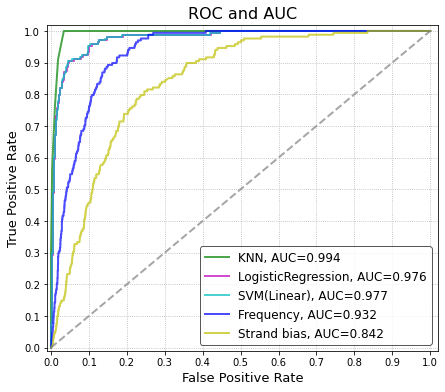

In [11]:
alpha = np.logspace(-3, 5, 100)
x = data[['Freq', 'StrandAF']]
y = data['Decision']
Freq = data['Freq']
StrandAF = data['StrandAF']
colors = cycle('gmc')
plt.figure(figsize=(7, 6), facecolor='w')
models = [['KNN', KNeighborsClassifier(n_neighbors=5)],
          ['LogisticRegression', LogisticRegressionCV(Cs=alpha, penalty='l2', cv=10)],
          ['SVM(Linear)', GridSearchCV(SVC(kernel='linear', decision_function_shape='ovo'), param_grid={'C': alpha}, cv=10)]]
for (name, model), color in zip(models, colors):
    model.fit(x, y)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(x)[:,1]
    else:
        y_score = model.decision_function(x)
    fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c=color, lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format(name, auc))

fpr, tpr, thresholds = metrics.roc_curve(y, Freq)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, c='b', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Frequency", auc))

fpr, tpr, thresholds = metrics.roc_curve(y, StrandAF)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, c='y', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Strand bias", auc))

plt.plot((0, 1), (0, 1), c='#808080', lw=2, ls='--', alpha=0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, edgecolor='#303030', fontsize=12)
plt.title('ROC and AUC', fontsize=16)
#plt.show()
plt.savefig("ROC and AUC.pdf", format="pdf")

### Plot logistic regression clusters

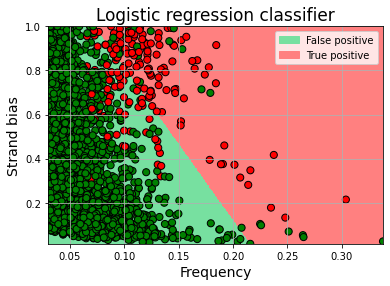

Logistic regression classifier accuracy = 96.929


In [12]:
data = pd.read_csv("minion_variants_positions_strandAF.tsv", sep="\t")
x = data[['Freq', 'StrandAF']]
y = data['Decision']

alpha = np.logspace(-3, 5, 100)
Logis_model = LogisticRegressionCV(Cs=alpha, penalty='l2', cv=10)
Logis_model.fit(x, y)
y_hat=Logis_model.predict(x)

x_array=x.to_numpy()
N, M = 500, 500 
x1_min, x1_max = x_array[:, 0].min(), x_array[:, 0].max()
x2_min, x2_max = x_array[:, 1].min(), x_array[:, 1].max()
t1=np.linspace(x1_min,x1_max,N)
t2=np.linspace(x2_min,x2_max,M)
x1, x2 = np.meshgrid(t1,t2)
x_test = np.stack((x1.flat, x2.flat), axis=1)
y_test = Logis_model.predict(x_test)
y_test = y_test.reshape(x1.shape) 

cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080'])
cm_dark = mpl.colors.ListedColormap(['g', 'r'])

plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_test, cmap=cm_light)
plt.scatter(x['Freq'], x['StrandAF'], c=y, edgecolors='k', s=50, cmap=cm_dark)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Strand bias', fontsize=14)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid()
patchs = [mpatches.Patch(color='#77E0A0', label='False positive'),
          mpatches.Patch(color='#FF8080', label='True positive')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8)
plt.title('Logistic regression classifier', fontsize=17)
plt.show()
print("Logistic regression classifier accuracy = {0:.3f}".format(100*accuracy_score(y, y_hat)))

### Plot SVC clusters

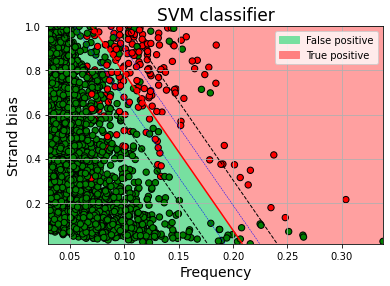

SVM classifer accuracy = 97.158


In [13]:
data = pd.read_csv("minion_variants_positions_strandAF.tsv", sep="\t")
x = data[['Freq', 'StrandAF']]
y = data['Decision']

alpha = np.logspace(-3, 5, 100)
SVC_model=GridSearchCV(SVC(kernel='linear', decision_function_shape='ovo'), param_grid={'C': alpha}, cv=10)
SVC_model.fit(x, y)
y_hat = SVC_model.predict(x)

x_array=x.to_numpy()
N, M = 500, 500 
x1_min, x1_max = x_array[:, 0].min(), x_array[:, 0].max()
x2_min, x2_max = x_array[:, 1].min(), x_array[:, 1].max()
t1=np.linspace(x1_min,x1_max,N)
t2=np.linspace(x2_min,x2_max,M)
x1, x2 = np.meshgrid(t1,t2)
x_test = np.stack((x1.flat, x2.flat), axis=1)
y_test = SVC_model.predict(x_test) 
y_test = y_test.reshape(x1.shape)

cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FFA0A0'])
cm_dark = mpl.colors.ListedColormap(['g', 'r'])

plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_test, cmap=cm_light, alpha=0.8)
plt.scatter(x['Freq'], x['StrandAF'], c=y, edgecolors='k', s=40, cmap=cm_dark)

z = SVC_model.decision_function(x_test)
z = z.reshape(x1.shape)
plt.contour(x1, x2, z, colors=list('kbrbk'), linestyles=['--', '--', '-', '--', '--'],
                    linewidths=[1, 0.5, 1.5, 0.5, 1], levels=[-1, -0.5, 0, 0.5, 1])

plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Strand bias', fontsize=14)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid()
patchs = [mpatches.Patch(color='#77E0A0', label='False positive'),
          mpatches.Patch(color='#FF8080', label='True positive')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8)
plt.title('SVM classifier', fontsize=17)
plt.show()
print("SVM classifer accuracy = {0:.3f}".format(100*accuracy_score(y, y_hat)))

### Plot KNN clusters

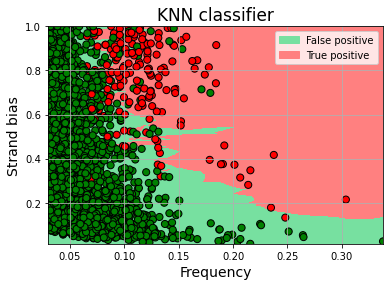

KNN classfier accuracy = 97.713


In [14]:
data = pd.read_csv("minion_variants_positions_strandAF.tsv", sep="\t")
x = data[['Freq', 'StrandAF']]
y = data['Decision']

alpha = np.logspace(-3, 5, 100)
KNN_model=KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(x, y)
y_hat = KNN_model.predict(x)

x_array=x.to_numpy()
N, M = 500, 500 
x1_min, x1_max = x_array[:, 0].min(), x_array[:, 0].max()
x2_min, x2_max = x_array[:, 1].min(), x_array[:, 1].max()
t1=np.linspace(x1_min,x1_max,N)
t2=np.linspace(x2_min,x2_max,M)
x1, x2 = np.meshgrid(t1,t2)
x_test = np.stack((x1.flat, x2.flat), axis=1)
y_test = KNN_model.predict(x_test)
y_test = y_test.reshape(x1.shape) 

cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080'])
cm_dark = mpl.colors.ListedColormap(['g', 'r'])

plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_test, cmap=cm_light)
plt.scatter(x['Freq'], x['StrandAF'], c=y, edgecolors='k', s=50, cmap=cm_dark)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Strand bias', fontsize=14)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid()
patchs = [mpatches.Patch(color='#77E0A0', label='False positive'),
          mpatches.Patch(color='#FF8080', label='True positive')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8)
plt.title('KNN classifier', fontsize=17)
plt.show()
print("KNN classfier accuracy = {0:.3f}".format(100*accuracy_score(y, y_hat)))

### In progress - unbalanced data 
It should be noted that this dataset is highly unbalanced. There are 168 true positive variants and 2893 false positive variants in "minion_variants_perfectMatch_strandAF.tsv". Note that this table contains three replica MinION runs. Therefore in "minion_variants_perfectMatch_strandAF.tsv", the variants should be counted three times. However, I did not confirm if each variant was counted three times at this moment. 

Next is to deal with the unbalance in the dataset. 